In [5]:
from collections import Counter

import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
from IPython.display import display

from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.metrics import classification_report_imbalanced
from imblearn.base import SamplerMixin

print(__doc__)


Automatically created module for IPython interactive environment


In [6]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_sample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
#     return Counter(y_res)


def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [7]:
df_raw = pd.read_csv('data/gcountBulk2.csv')
df = df_raw.iloc[:,145:].transpose()

gene_name = df_raw.iloc[:,0]
df.columns = gene_name
df['label'] = [0,1,1,1,2,2,3,3,3,3]

# drop all dermal as only 1 raw sample given
df = df[df.label != 0]
display(df)
print(sorted(Counter(df.label).items()))

Unnamed: 0,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,...,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,label
bulk_neuralTube1,1,250,137,13,761,41,0,485,0,333,...,368,2482,147,235,334,462,305,215,588,1
bulk_neuralTube2,9,418,149,22,1298,101,0,769,0,472,...,604,3528,234,387,461,638,509,353,1066,1
bulk_neuralTube3,1,602,478,24,882,165,1215,797,0,851,...,365,4956,118,87,265,597,511,96,486,1
bulk_BAT1,26,2704,211,32,2090,184,0,2188,0,1596,...,1207,9029,349,1170,719,1412,4542,906,1397,2
bulk_BAT2,18,1877,206,44,1895,118,0,1942,0,1326,...,1041,7509,296,941,577,1476,2994,748,947,2
bulk_muscle1,26,1178,243,41,3447,280,0,2204,0,1495,...,2125,4322,401,1453,1215,1347,6908,567,1680,3
bulk_muscle2,21,1145,355,33,2603,204,0,1899,0,990,...,2022,4321,437,828,742,1203,3478,288,1386,3
bulk_muscle3,0,650,1102,113,955,0,1132,1118,0,4204,...,0,4173,23,809,13,32,1358,0,0,3
bulk_muscle4,11,377,797,317,1571,36,302,693,0,2133,...,125,2530,111,39,299,284,1479,102,185,3


[(1, 3), (2, 2), (3, 4)]


In [8]:
# for every cell type -> every gene (column) mean & std -> noise*factor -> append all genes on axis=1 (factor,21713)
labels = df.label.unique()

# labels = [0]
factor = 100
genes = 20713
df_bootstrap = df.copy()

print labels

for cell_type in labels: #for each cell type

    print 'replicate cell type: ' + str(cell_type)
    df_cell = df.loc[df.label == cell_type]
    df_cell.drop('label', axis=1, inplace=True)

    print df_cell.shape
    print '///'
#     new_genes = np.empty([factor, None])
    new_genes = []
    for index,column in enumerate(df_cell): #for each gene of a cell
        mean = df_cell[column].mean()
        std = df_cell[column].std()
        if index%1000 ==0:
            print 'compute ' +str(index)
            
        if float(std)==0.0: #for previosue 1 raw sample
                std=1.0 
        gene_col = np.random.normal(mean,std,(factor, 1))

        new_genes.append(gene_col)
    print 'complete replicating'
    replicates = np.array(new_genes).T 
    replicates = replicates.reshape(factor,genes)
    
    replicate_label = np.tile([cell_type],(factor,1))
    replicates = np.append(replicates, replicate_label, axis=1)

    print replicates.shape #replicate of all genes of 1 cell type
    df_replicate = pd.DataFrame(data=replicates,columns=df.columns)
    df_bootstrap = df_bootstrap.append(df_replicate, ignore_index=True)

print 'complete all labels'
display(df_bootstrap)
print(sorted(Counter(df_bootstrap.label).items()))

[1 2 3]
replicate cell type: 1
(3, 20713)
///
compute 0


/Users/MartinShin/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


compute 1000
compute 2000
compute 3000
compute 4000
compute 5000
compute 6000
compute 7000
compute 8000
compute 9000
compute 10000
compute 11000
compute 12000
compute 13000
compute 14000
compute 15000
compute 16000
compute 17000
compute 18000
compute 19000
compute 20000
complete replicating
(1, 100, 20713)
///
(100, 20714)
replicate cell type: 2
(2, 20713)
///
compute 0
compute 1000
compute 2000
compute 3000
compute 4000
compute 5000
compute 6000
compute 7000
compute 8000
compute 9000
compute 10000
compute 11000
compute 12000
compute 13000
compute 14000
compute 15000
compute 16000
compute 17000
compute 18000
compute 19000
compute 20000
complete replicating
(1, 100, 20713)
///
(100, 20714)
replicate cell type: 3
(4, 20713)
///
compute 0
compute 1000
compute 2000
compute 3000
compute 4000
compute 5000
compute 6000
compute 7000
compute 8000
compute 9000
compute 10000
compute 11000
compute 12000
compute 13000
compute 14000
compute 15000
compute 16000
compute 17000
compute 18000
compute 190

Unnamed: 0,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,...,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,label
0,1.000000,250.000000,137.000000,13.000000,761.000000,41.000000,0.000000,485.000000,0.000000,333.000000,...,368.000000,2482.000000,147.000000,235.000000,334.000000,462.000000,305.000000,215.000000,588.000000,1.0
1,9.000000,418.000000,149.000000,22.000000,1298.000000,101.000000,0.000000,769.000000,0.000000,472.000000,...,604.000000,3528.000000,234.000000,387.000000,461.000000,638.000000,509.000000,353.000000,1066.000000,1.0
2,1.000000,602.000000,478.000000,24.000000,882.000000,165.000000,1215.000000,797.000000,0.000000,851.000000,...,365.000000,4956.000000,118.000000,87.000000,265.000000,597.000000,511.000000,96.000000,486.000000,1.0
3,26.000000,2704.000000,211.000000,32.000000,2090.000000,184.000000,0.000000,2188.000000,0.000000,1596.000000,...,1207.000000,9029.000000,349.000000,1170.000000,719.000000,1412.000000,4542.000000,906.000000,1397.000000,2.0
4,18.000000,1877.000000,206.000000,44.000000,1895.000000,118.000000,0.000000,1942.000000,0.000000,1326.000000,...,1041.000000,7509.000000,296.000000,941.000000,577.000000,1476.000000,2994.000000,748.000000,947.000000,2.0
5,26.000000,1178.000000,243.000000,41.000000,3447.000000,280.000000,0.000000,2204.000000,0.000000,1495.000000,...,2125.000000,4322.000000,401.000000,1453.000000,1215.000000,1347.000000,6908.000000,567.000000,1680.000000,3.0
6,21.000000,1145.000000,355.000000,33.000000,2603.000000,204.000000,0.000000,1899.000000,0.000000,990.000000,...,2022.000000,4321.000000,437.000000,828.000000,742.000000,1203.000000,3478.000000,288.000000,1386.000000,3.0
7,0.000000,650.000000,1102.000000,113.000000,955.000000,0.000000,1132.000000,1118.000000,0.000000,4204.000000,...,0.000000,4173.000000,23.000000,809.000000,13.000000,32.000000,1358.000000,0.000000,0.000000,3.0
8,11.000000,377.000000,797.000000,317.000000,1571.000000,36.000000,302.000000,693.000000,0.000000,2133.000000,...,125.000000,2530.000000,111.000000,39.000000,299.000000,284.000000,1479.000000,102.000000,185.000000,3.0
9,5.306946,452.373814,643.402075,22.843203,1114.351617,108.217161,493.192111,1098.152048,0.200883,255.839003,...,360.227715,4059.635283,224.336781,178.693122,318.013296,695.892129,337.009797,147.782237,1187.067027,1.0


[(1.0, 103), (2.0, 102), (3.0, 104)]


In [9]:
# # make even label distribution
# ros = RandomOverSampler(random_state=0)
# # smote = SMOTE(random_state=0)

# predictors = [x for x in df.columns if x not in ['label_name', 'label']]
# # X = df[predictors]
# X = df.drop(['label'], axis=1)
# y = df.label
# X_resampled, y_resampled = ros.fit_sample(X.values, y)

# print(sorted(Counter(y_resampled).items()))
# print 'X_resampled shape'
# print type(X_resampled)
# # y_resampled = y_resampled.reshape(16,1)
# print y_resampled
# print y_resampled.shape


In [10]:
# df_sampled = pd.DataFrame(data=X_resampled, columns=predictors)

# df_sampled['label'] = y_resampled
# display(df_sampled)

In [11]:
# # Make an identity sampler
# class FakeSampler(SamplerMixin):

#     def fit(self, X, y):
#         self.ratio_ = 1
#         self.X_hash_ = hash_X_y(X, y)
#         return self

#     def sample(self, X, y):
#         return X,

#     def _sample(self, X, y):
#         pass

#     def fit_sample(self, X, y):
#         return X, y
    
# fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 15))
# sampler = FakeSampler()
# plot_resampling(X_resampled, y_resampled, sampler, ax1)
# ax1.set_title('Original data - y={}'.format(Counter(y)))

# X_multiplied,y_multiplied = df_bootstrap.iloc[:,0:-2].values, df_bootstrap['label'].values
# plot_resampling(X_multiplied,y_multiplied, sampler, ax2)
# ax2.set_title('Bootstrap data - y={}'.format(Counter(y_multiplied)))

# plt.show()

In [12]:
df_bootstrap.to_csv('data/bootstrap.csv')

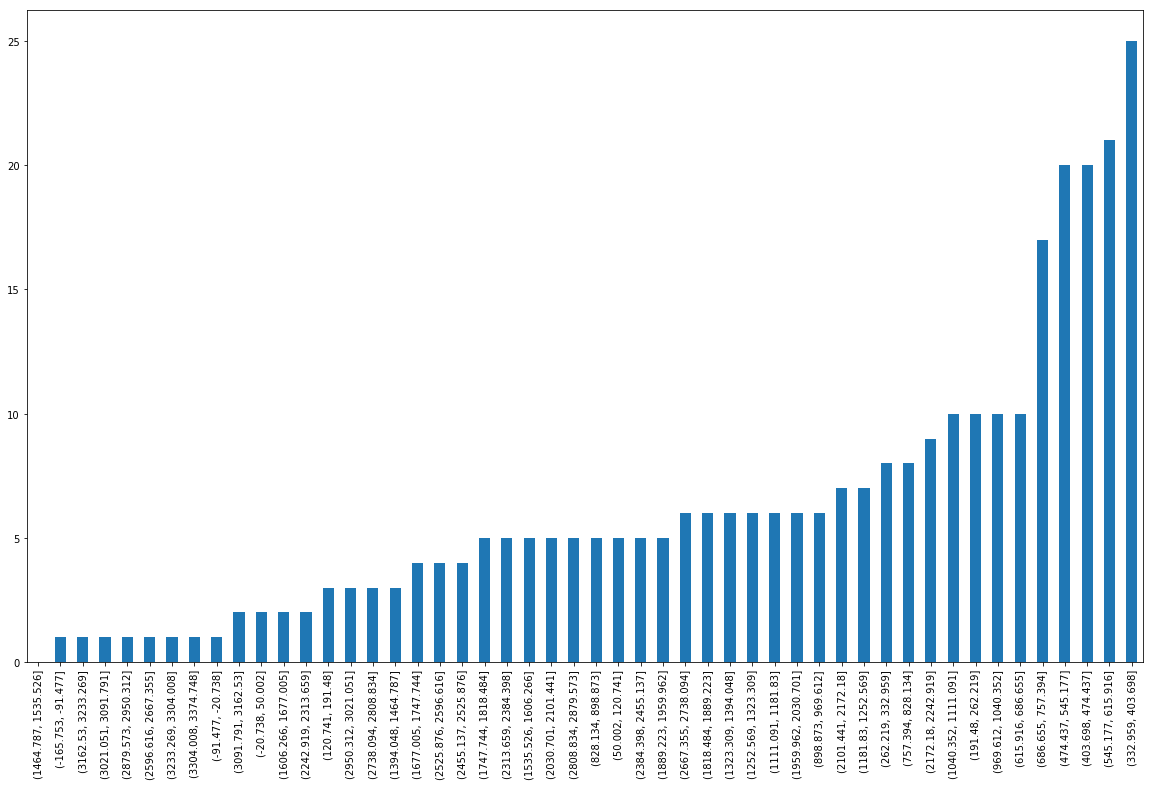

In [20]:
# [0, 10, 50, 100, 150]
width = 20
height = 12
plt.figure(figsize=(width, height))

cuts = pd.cut(df_bootstrap['0610007P14Rik'], 50)
cuts.value_counts(ascending=True).plot(kind='bar')
plt.show()

In [21]:
print cuts

0         (191.48, 262.219]
1        (403.698, 474.437]
2        (545.177, 615.916]
3      (2667.355, 2738.094]
4      (1818.484, 1889.223]
5       (1111.091, 1181.83]
6       (1111.091, 1181.83]
7        (615.916, 686.655]
8        (332.959, 403.698]
9        (403.698, 474.437]
10       (332.959, 403.698]
11       (403.698, 474.437]
12       (757.394, 828.134]
13        (50.002, 120.741]
14       (403.698, 474.437]
15       (474.437, 545.177]
16       (403.698, 474.437]
17       (686.655, 757.394]
18       (686.655, 757.394]
19       (403.698, 474.437]
20       (545.177, 615.916]
21        (50.002, 120.741]
22       (332.959, 403.698]
23       (686.655, 757.394]
24       (332.959, 403.698]
25       (332.959, 403.698]
26       (332.959, 403.698]
27       (545.177, 615.916]
28       (332.959, 403.698]
29       (332.959, 403.698]
               ...         
279     (969.612, 1040.352]
280     (1111.091, 1181.83]
281       (191.48, 262.219]
282     (969.612, 1040.352]
283     (1111.091, 1

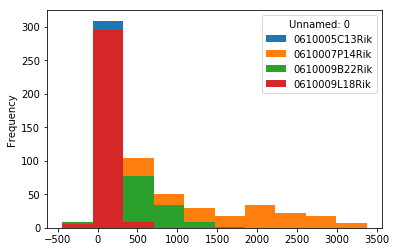

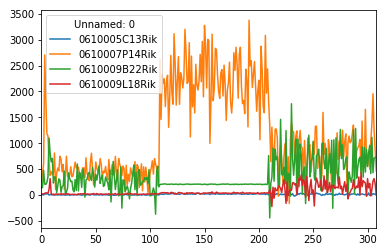

In [33]:
hist = df_bootstrap.iloc[:,0:4]
# hist = df_bootstrap.iloc[:,0]
plt.figure(figsize=(width, height))
hist.plot.hist()
hist.plot.line()
plt.show()

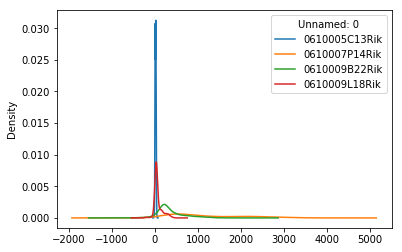

In [34]:
plt.figure(figsize=(width, height))
hist.plot.kde()
plt.show()